In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os
import numpy as np
from PIL import Image
import torchvision.models as models
import mean_iou_evaluate
import viz_mask
import imageio
from tqdm import tqdm
from torchsummary import summary


In [23]:
class HW2IMGS(Dataset):
    def __init__(self, root, transform=None):
        " initial the dataset "
        self.X_image = None
        self.y_label = None
        self.X_filenames = []
        self.y_filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        X_filenames = glob.glob(root+'/*.jpg')
        y_filenames = glob.glob(root+'/*.png')
        for i in range(len(X_filenames)):
            self.X_filenames.append(os.path.splitext(os.path.basename(X_filenames[i]))[0])
            self.y_filenames.append(os.path.splitext(os.path.basename(y_filenames[i]))[0])

        self.len = len(self.X_filenames)

    def __getitem__(self, index):
        X_filename, y_filename = self.X_filenames[index], self.y_filenames[index]

        X_image = Image.open(self.root+X_filename+'.jpg')
        X_shape = imageio.imread(self.root+X_filename+'.jpg').shape

        y_image = imageio.imread(self.root+y_filename+'.png')
        y_label = viz_mask.read_masks(y_image, X_shape)

        if self.transform is not None:
            X_image = self.transform(X_image)
        return X_image, y_label

    def __len__(self):
        " Total number of sampler in the dataset "
        return self.len


In [24]:
from torchvision import transforms
trainset = HW2IMGS(root='p2_data/train/', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
]))

valset = HW2IMGS(root='p2_data/validation/', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
]))
print(len(trainset))
print(len(valset))


2000
257


In [25]:
trainset_loader = DataLoader(trainset, batch_size=4, shuffle=True)
valset_loader = DataLoader(valset, batch_size=4, shuffle=False)

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [27]:
# from torchsummary import summary
# # summary(vgg, (3, 512, 512))

# class FCN32(nn.Module):
#     def __init__(self):
#         super(FCN32, self).__init__()
#         self.vgg_feature = models.vgg16(pretrained=True).features

#         self.vgg_fc = nn.Sequential(
#             nn.Conv2d(512, 4096, 1),
#             nn.ReLU(),
#             nn.Conv2d(4096, 4096, 1),
#             nn.ReLU(),
#             nn.Conv2d(4096, 7, 1),
#             nn.ReLU(),
#             nn.ConvTranspose2d(7, 7, 32, 32),
#         )

#     def forward(self, x):
#         x = self.vgg_feature(x)
#         x = self.vgg_fc(x)
#         return x


# model = FCN32().to(device)  # Remember to move the model to "device"
# #summary(model, (3, 512, 512))

In [7]:
class FCN8(nn.Module):
    def __init__(self):
        super(FCN8, self).__init__()
        self.vgg_feature = models.vgg16(pretrained=True).features

        self.p0_p3 = self.vgg_feature[:17]
        self.p3_p4 = self.vgg_feature[17:24]
        self.p4_p5 = self.vgg_feature[24:31]
        
        #upsample 2x
        self.up2x = nn.Upsample(scale_factor= 2 , mode='bilinear', align_corners=True)
        #upsample 8x
        self.ct8x = nn.Sequential(
            nn.ConvTranspose2d(256,7,8,8),
            nn.ReLU()
        )
        #shape channel from 512 to 256
        self.ct = nn.Sequential(
            nn.ConvTranspose2d(512,256,2,stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        p3 = self.p0_p3(x)
        p4 = self.p3_p4(p3)
        p5 = self.p4_p5(p4)

        p4p5 = self.up2x(p5) + p4
        p4p5 = self.ct(p4p5)
        p3p4p5 = p4p5+p3

        x = self.ct8x(p3p4p5)
        return x


model = FCN8().to(device)  # Remember to move the model to "device"
summary(model, (3, 512, 512))
print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
            Conv2d-2         [-1, 64, 512, 512]           1,792
              ReLU-3         [-1, 64, 512, 512]               0
              ReLU-4         [-1, 64, 512, 512]               0
            Conv2d-5         [-1, 64, 512, 512]          36,928
            Conv2d-6         [-1, 64, 512, 512]          36,928
              ReLU-7         [-1, 64, 512, 512]               0
              ReLU-8         [-1, 64, 512, 512]               0
         MaxPool2d-9         [-1, 64, 256, 256]               0
        MaxPool2d-10         [-1, 64, 256, 256]               0
           Conv2d-11        [-1, 128, 256, 256]          73,856
           Conv2d-12        [-1, 128, 256, 256]          73,856
             ReLU-13        [-1, 128, 256, 256]               0
             ReLU-14        [-1, 128, 2

In [8]:
# a = torch.randn((1,512,16,16))  #P5
# b = torch.randn((1,512,32,32))  #P4
# c = torch.randn((1,256,64,64))  #P3

# up2times = nn.Upsample(scale_factor= 2 , mode='bilinear', align_corners=True)
# cc = nn.ConvTranspose2d(512,256,2,stride=2)
# convtranspose8x = nn.ConvTranspose2d(256,7,8,8)


# ab =up2times(a)+b
# # print(ab.shape)
# ab = cc(ab)
# abc = ab+c
# # print(abc.shape)
# abc = convtranspose8x(abc)
# # print(abc.shape)


In [9]:
# a = models.vgg16(pretrained=True).features
# b = a[:17]
# c = a[17:24]
# d = a[24:31]

# print(b)
# print(c)
# print(d)



In [10]:

# summary(model, (3,512,512))

In [11]:
import matplotlib.pyplot as plt
train_acc_his, train_loss_his = [], []
val_acc_his, val_loss_his = [], []

In [12]:
def train(model, epoch, log_interval=200):
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()  # Important: set training mode

    for ep in range(epoch):
        outs = np.empty((0,512,512))
        tars = np.empty((0,512,512))
        iteration = 0
        correct = 0
        total_train = 0
        for batch_idx, (data, target) in enumerate(tqdm(trainset_loader)):

            loss = 0.0
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            output = model(data)

            output = torch.nn.functional.log_softmax(output, dim=1)
            target = torch.tensor(target, dtype=torch.long, device=device)
            loss = criterion(output, target)

            loss.backward()
            optimizer.step()



            # get the index of the max log-probability
            total_train += target.nelement()
            pred = output.max(1, keepdim=True)[1]
            pred = pred.eq(target.view_as(pred))



            # print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            iteration+=1
            

            #prepare data for mean-IOU
            pred = output.max(1, keepdim=False)[1].cpu().numpy()
            labels = target.cpu().numpy()
            outs = np.concatenate((outs,pred))
            tars = np.concatenate((tars,labels))


            if (iteration % log_interval == 0):
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
                    ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item(),
                    correct, total_train,
                    100. * correct / total_train))
                
        mean_iou_evaluate.mean_iou_score(outs,tars)
        train_acc_his.append(100. * correct / len(trainset_loader.dataset))
        train_loss_his.append(loss.item())
        val(model,ep)  # Evaluate at the end of each epoch
        scheduler.step()

    # summarize history for accuracy
    plt.plot(train_acc_his)
    plt.plot(val_acc_his)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
    plt.plot(train_loss_his)
    plt.plot(val_loss_his)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [13]:
def val(model,ep):
    criterion = nn.CrossEntropyLoss()
    model.eval()  # Important: set evaluation mode
    val_loss = 0
    correct = 0
    total_val = 0
    outs = np.empty((0,512,512))
    tars = np.empty((0,512,512))

    with torch.no_grad():  # This will free the GPU memory used for back-prop
        for data, target in valset_loader:
            
            data, target = data.to(device), target.to(device)
            output = model(data)

            output = torch.nn.functional.log_softmax(output, dim=1)
            # print(output.shape, target.shape)
            target = torch.tensor(target, dtype=torch.long, device=device)
            # target.clone().detach()
            val_loss += criterion(output, target).item()
            total_val += target.nelement()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

            pred = output.max(1, keepdim=False)[1].cpu().numpy()
            labels = target.cpu().numpy()

            outs = np.concatenate((outs,pred))
            tars = np.concatenate((tars,labels))
            
    miou = mean_iou_evaluate.mean_iou_score(outs,tars)
    if(miou>0.63):
        torch.save(model, ('.//seg{}.pth').format(ep),_use_new_zipfile_serialization=False)

    val_loss /= len(valset_loader.dataset)
    print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, total_val,
        100. * correct / total_val))

    val_acc_his.append(100. * correct / len(valset_loader.dataset))
    val_loss_his.append(val_loss)


In [14]:
# def outputpred(model,filename):
#     X = Image.open(filename)
#     X = X.to(device)
#     masks = model(X)
#     print(masks)
#     # cs = np.unique(masks)

#     # for c in cs:
#     #     mask = np.zeros((img.shape[0], img.shape[1]))
#     #     ind = np.where(masks==c)
#     #     mask[ind[0], ind[1]] = 1
#     #     img = viz_mask.viz_data(img, mask, color=viz_mask.cmap[c])
#     #     imageio.imsave('./exp.png', np.uint8(img))


In [15]:
# outputpred(model,'p2_data\\validation\\0236_sat.jpg')

  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-12-32c28201d4ae>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long, device=device)
 40%|████      | 200/500 [05:25<10:23,  2.08s/it]

Train Epoch: 1 [796/2000 (40%)]	Loss: 1.684623, Accuracy: 125724445/209715200 (60%)


 80%|████████  | 400/500 [13:57<05:00,  3.00s/it]

Train Epoch: 1 [1596/2000 (80%)]	Loss: 1.109191, Accuracy: 241866879/419430400 (58%)


100%|██████████| 500/500 [19:26<00:00,  2.33s/it]


class #0 : 0.39494
class #1 : 0.67618
class #2 : 0.01168
class #3 : 0.34094
class #4 : 0.18117
class #5 : 0.05814

mean_iou: 0.277174



<ipython-input-13-04731e6e7b8b>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.long, device=device)


class #0 : 0.62341
class #1 : 0.75551
class #2 : 0.00727
class #3 : 0.43449
class #4 : 0.46274
class #5 : 0.26940

mean_iou: 0.425471


Val set: Average loss: 0.1912, Accuracy: 51543914/67371008 (77%)



 40%|████      | 200/500 [05:19<10:09,  2.03s/it]

Train Epoch: 2 [796/2000 (40%)]	Loss: 0.449719, Accuracy: 118026824/209715200 (56%)


 80%|████████  | 400/500 [13:46<05:01,  3.01s/it]

Train Epoch: 2 [1596/2000 (80%)]	Loss: 0.496973, Accuracy: 238450206/419430400 (57%)


100%|██████████| 500/500 [19:10<00:00,  2.30s/it]


class #0 : 0.62911
class #1 : 0.78609
class #2 : 0.01236
class #3 : 0.62929
class #4 : 0.51653
class #5 : 0.36513

mean_iou: 0.489753

class #0 : 0.64527
class #1 : 0.83178
class #2 : 0.04407
class #3 : 0.69975
class #4 : 0.49315
class #5 : 0.52045

mean_iou: 0.539079


Val set: Average loss: 0.1398, Accuracy: 55594367/67371008 (83%)



 40%|████      | 200/500 [05:19<10:17,  2.06s/it]

Train Epoch: 3 [796/2000 (40%)]	Loss: 0.943802, Accuracy: 118412357/209715200 (56%)


 80%|████████  | 400/500 [13:41<04:53,  2.93s/it]

Train Epoch: 3 [1596/2000 (80%)]	Loss: 0.600293, Accuracy: 239718497/419430400 (57%)


100%|██████████| 500/500 [19:02<00:00,  2.28s/it]


class #0 : 0.66193
class #1 : 0.81390
class #2 : 0.04147
class #3 : 0.67437
class #4 : 0.54643
class #5 : 0.45081

mean_iou: 0.531484

class #0 : 0.66189
class #1 : 0.84214
class #2 : 0.08092
class #3 : 0.69907
class #4 : 0.54025
class #5 : 0.53970

mean_iou: 0.560662


Val set: Average loss: 0.1303, Accuracy: 55945525/67371008 (83%)



 40%|████      | 200/500 [05:20<10:10,  2.03s/it]

Train Epoch: 4 [796/2000 (40%)]	Loss: 0.510732, Accuracy: 117256395/209715200 (56%)


 80%|████████  | 400/500 [13:47<04:56,  2.97s/it]

Train Epoch: 4 [1596/2000 (80%)]	Loss: 0.328828, Accuracy: 237565639/419430400 (57%)


100%|██████████| 500/500 [19:13<00:00,  2.31s/it]


class #0 : 0.67758
class #1 : 0.82992
class #2 : 0.13649
class #3 : 0.68987
class #4 : 0.56837
class #5 : 0.49733

mean_iou: 0.566595

class #0 : 0.66732
class #1 : 0.85129
class #2 : 0.13468
class #3 : 0.69620
class #4 : 0.57318
class #5 : 0.56000

mean_iou: 0.580446


Val set: Average loss: 0.1207, Accuracy: 56645720/67371008 (84%)



 40%|████      | 200/500 [05:20<10:03,  2.01s/it]

Train Epoch: 5 [796/2000 (40%)]	Loss: 0.193923, Accuracy: 119825607/209715200 (57%)


 80%|████████  | 400/500 [13:44<04:52,  2.92s/it]

Train Epoch: 5 [1596/2000 (80%)]	Loss: 0.679731, Accuracy: 236546962/419430400 (56%)


100%|██████████| 500/500 [19:08<00:00,  2.30s/it]


class #0 : 0.68331
class #1 : 0.84056
class #2 : 0.19795
class #3 : 0.69549
class #4 : 0.60024
class #5 : 0.52512

mean_iou: 0.590445

class #0 : 0.67014
class #1 : 0.84890
class #2 : 0.10360
class #3 : 0.71010
class #4 : 0.58369
class #5 : 0.57041

mean_iou: 0.581139


Val set: Average loss: 0.1187, Accuracy: 56654132/67371008 (84%)



 40%|████      | 200/500 [05:19<10:04,  2.01s/it]

Train Epoch: 6 [796/2000 (40%)]	Loss: 0.476781, Accuracy: 121189767/209715200 (58%)


 80%|████████  | 400/500 [13:45<04:55,  2.96s/it]

Train Epoch: 6 [1596/2000 (80%)]	Loss: 0.250369, Accuracy: 238262616/419430400 (57%)


100%|██████████| 500/500 [19:10<00:00,  2.30s/it]


class #0 : 0.69138
class #1 : 0.85338
class #2 : 0.24724
class #3 : 0.72468
class #4 : 0.60747
class #5 : 0.55560

mean_iou: 0.613294

class #0 : 0.67429
class #1 : 0.86826
class #2 : 0.18373
class #3 : 0.75496
class #4 : 0.59952
class #5 : 0.61939

mean_iou: 0.616690


Val set: Average loss: 0.1057, Accuracy: 57727227/67371008 (86%)



 40%|████      | 200/500 [05:20<10:08,  2.03s/it]

Train Epoch: 7 [796/2000 (40%)]	Loss: 0.311092, Accuracy: 118348128/209715200 (56%)


 80%|████████  | 400/500 [13:43<04:51,  2.91s/it]

Train Epoch: 7 [1596/2000 (80%)]	Loss: 0.376583, Accuracy: 238318863/419430400 (57%)


100%|██████████| 500/500 [19:01<00:00,  2.28s/it]


class #0 : 0.69441
class #1 : 0.86633
class #2 : 0.28699
class #3 : 0.73868
class #4 : 0.61374
class #5 : 0.58854

mean_iou: 0.631447

class #0 : 0.68581
class #1 : 0.87158
class #2 : 0.22205
class #3 : 0.75337
class #4 : 0.60085
class #5 : 0.62763

mean_iou: 0.626882


Val set: Average loss: 0.1032, Accuracy: 57918382/67371008 (86%)



 40%|████      | 200/500 [05:20<10:09,  2.03s/it]

Train Epoch: 8 [796/2000 (40%)]	Loss: 0.531261, Accuracy: 117971925/209715200 (56%)


 80%|████████  | 400/500 [13:43<04:58,  2.99s/it]

Train Epoch: 8 [1596/2000 (80%)]	Loss: 0.363059, Accuracy: 239593295/419430400 (57%)


100%|██████████| 500/500 [19:03<00:00,  2.29s/it]


class #0 : 0.70075
class #1 : 0.87418
class #2 : 0.31362
class #3 : 0.75551
class #4 : 0.62532
class #5 : 0.60187

mean_iou: 0.645207

class #0 : 0.67179
class #1 : 0.87126
class #2 : 0.23502
class #3 : 0.75888
class #4 : 0.61185
class #5 : 0.63941

mean_iou: 0.631368



C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:404: UserWarning: Couldn't retrieve source code for container of type FCN8. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "



Val set: Average loss: 0.1024, Accuracy: 58049829/67371008 (86%)



 40%|████      | 200/500 [05:19<10:04,  2.02s/it]

Train Epoch: 9 [796/2000 (40%)]	Loss: 0.312485, Accuracy: 123766773/209715200 (59%)


 80%|████████  | 400/500 [13:35<04:55,  2.95s/it]

Train Epoch: 9 [1596/2000 (80%)]	Loss: 0.360390, Accuracy: 241564118/419430400 (58%)


100%|██████████| 500/500 [18:51<00:00,  2.26s/it]


class #0 : 0.70268
class #1 : 0.88116
class #2 : 0.34944
class #3 : 0.75981
class #4 : 0.63585
class #5 : 0.64619

mean_iou: 0.662522

class #0 : 0.66144
class #1 : 0.87705
class #2 : 0.25852
class #3 : 0.76109
class #4 : 0.61478
class #5 : 0.63779

mean_iou: 0.635112


Val set: Average loss: 0.1008, Accuracy: 58011660/67371008 (86%)



 40%|████      | 200/500 [05:17<10:08,  2.03s/it]

Train Epoch: 10 [796/2000 (40%)]	Loss: 0.967745, Accuracy: 117109732/209715200 (56%)


 80%|████████  | 400/500 [13:33<04:50,  2.91s/it]

Train Epoch: 10 [1596/2000 (80%)]	Loss: 0.217749, Accuracy: 237204348/419430400 (57%)


100%|██████████| 500/500 [18:48<00:00,  2.26s/it]


class #0 : 0.70565
class #1 : 0.89012
class #2 : 0.37387
class #3 : 0.77246
class #4 : 0.64513
class #5 : 0.65641

mean_iou: 0.673941

class #0 : 0.68497
class #1 : 0.87900
class #2 : 0.22035
class #3 : 0.75041
class #4 : 0.62143
class #5 : 0.65164

mean_iou: 0.634634


Val set: Average loss: 0.0999, Accuracy: 58303495/67371008 (87%)



 40%|████      | 200/500 [05:16<09:58,  1.99s/it]

Train Epoch: 11 [796/2000 (40%)]	Loss: 0.286426, Accuracy: 123442712/209715200 (59%)


 80%|████████  | 400/500 [13:29<04:50,  2.91s/it]

Train Epoch: 11 [1596/2000 (80%)]	Loss: 0.331728, Accuracy: 238080458/419430400 (57%)


100%|██████████| 500/500 [18:43<00:00,  2.25s/it]


class #0 : 0.70783
class #1 : 0.89491
class #2 : 0.39872
class #3 : 0.77675
class #4 : 0.65424
class #5 : 0.68485

mean_iou: 0.686214

class #0 : 0.66428
class #1 : 0.87540
class #2 : 0.27319
class #3 : 0.75251
class #4 : 0.63228
class #5 : 0.61716

mean_iou: 0.635803


Val set: Average loss: 0.1042, Accuracy: 57932389/67371008 (86%)



 40%|████      | 200/500 [05:16<09:56,  1.99s/it]

Train Epoch: 12 [796/2000 (40%)]	Loss: 0.229233, Accuracy: 117713351/209715200 (56%)


 80%|████████  | 400/500 [13:32<04:51,  2.91s/it]

Train Epoch: 12 [1596/2000 (80%)]	Loss: 0.289419, Accuracy: 242023464/419430400 (58%)


100%|██████████| 500/500 [18:48<00:00,  2.26s/it]


class #0 : 0.70877
class #1 : 0.90330
class #2 : 0.42663
class #3 : 0.78731
class #4 : 0.66159
class #5 : 0.71631

mean_iou: 0.700651

class #0 : 0.67199
class #1 : 0.88158
class #2 : 0.26468
class #3 : 0.75992
class #4 : 0.62428
class #5 : 0.64148

mean_iou: 0.640657


Val set: Average loss: 0.1020, Accuracy: 58217840/67371008 (86%)



 40%|████      | 200/500 [05:16<09:54,  1.98s/it]

Train Epoch: 13 [796/2000 (40%)]	Loss: 0.152287, Accuracy: 119959837/209715200 (57%)


 80%|████████  | 400/500 [13:28<04:51,  2.91s/it]

Train Epoch: 13 [1596/2000 (80%)]	Loss: 0.525111, Accuracy: 243165404/419430400 (58%)


100%|██████████| 500/500 [18:43<00:00,  2.25s/it]


class #0 : 0.70871
class #1 : 0.91101
class #2 : 0.45136
class #3 : 0.79491
class #4 : 0.66869
class #5 : 0.73328

mean_iou: 0.711327

class #0 : 0.66710
class #1 : 0.87795
class #2 : 0.30565
class #3 : 0.76094
class #4 : 0.62796
class #5 : 0.63606

mean_iou: 0.645943


Val set: Average loss: 0.1015, Accuracy: 58045742/67371008 (86%)



 40%|████      | 200/500 [05:15<09:56,  1.99s/it]

Train Epoch: 14 [796/2000 (40%)]	Loss: 0.469663, Accuracy: 119519250/209715200 (57%)


 80%|████████  | 400/500 [13:28<04:49,  2.89s/it]

Train Epoch: 14 [1596/2000 (80%)]	Loss: 0.264130, Accuracy: 239395841/419430400 (57%)


100%|██████████| 500/500 [18:42<00:00,  2.24s/it]


class #0 : 0.70930
class #1 : 0.91933
class #2 : 0.49150
class #3 : 0.80349
class #4 : 0.67495
class #5 : 0.76136

mean_iou: 0.726654

class #0 : 0.67280
class #1 : 0.88032
class #2 : 0.28113
class #3 : 0.76946
class #4 : 0.63157
class #5 : 0.62902

mean_iou: 0.644049


Val set: Average loss: 0.1045, Accuracy: 58215910/67371008 (86%)



 40%|████      | 200/500 [05:16<09:58,  1.99s/it]

Train Epoch: 15 [796/2000 (40%)]	Loss: 0.198710, Accuracy: 122747138/209715200 (59%)


 80%|████████  | 400/500 [13:28<04:49,  2.90s/it]

Train Epoch: 15 [1596/2000 (80%)]	Loss: 0.276297, Accuracy: 242956483/419430400 (58%)


100%|██████████| 500/500 [18:42<00:00,  2.25s/it]


class #0 : 0.71293
class #1 : 0.92626
class #2 : 0.50914
class #3 : 0.81013
class #4 : 0.68204
class #5 : 0.78492

mean_iou: 0.737570

class #0 : 0.66812
class #1 : 0.88163
class #2 : 0.30288
class #3 : 0.76995
class #4 : 0.63455
class #5 : 0.63328

mean_iou: 0.648402


Val set: Average loss: 0.1015, Accuracy: 58348038/67371008 (87%)



 40%|████      | 200/500 [05:15<09:56,  1.99s/it]

Train Epoch: 16 [796/2000 (40%)]	Loss: 0.263983, Accuracy: 121567753/209715200 (58%)


 80%|████████  | 400/500 [13:35<05:01,  3.01s/it]

Train Epoch: 16 [1596/2000 (80%)]	Loss: 0.206043, Accuracy: 241221897/419430400 (58%)


100%|██████████| 500/500 [18:56<00:00,  2.27s/it]


class #0 : 0.71445
class #1 : 0.93008
class #2 : 0.53302
class #3 : 0.81965
class #4 : 0.68560
class #5 : 0.80079

mean_iou: 0.747266

class #0 : 0.65489
class #1 : 0.88049
class #2 : 0.31267
class #3 : 0.76483
class #4 : 0.63840
class #5 : 0.63488

mean_iou: 0.647693


Val set: Average loss: 0.1058, Accuracy: 58186578/67371008 (86%)



 40%|████      | 200/500 [05:19<10:01,  2.01s/it]

Train Epoch: 17 [796/2000 (40%)]	Loss: 0.404869, Accuracy: 121444595/209715200 (58%)


 80%|████████  | 400/500 [13:35<04:51,  2.91s/it]

Train Epoch: 17 [1596/2000 (80%)]	Loss: 0.205786, Accuracy: 242189940/419430400 (58%)


100%|██████████| 500/500 [18:58<00:00,  2.28s/it]


class #0 : 0.71622
class #1 : 0.93665
class #2 : 0.55507
class #3 : 0.82848
class #4 : 0.69074
class #5 : 0.81509

mean_iou: 0.757042

class #0 : 0.66136
class #1 : 0.87928
class #2 : 0.29285
class #3 : 0.76185
class #4 : 0.63933
class #5 : 0.63160

mean_iou: 0.644379


Val set: Average loss: 0.1083, Accuracy: 58229944/67371008 (86%)



 40%|████      | 200/500 [05:19<10:00,  2.00s/it]

Train Epoch: 18 [796/2000 (40%)]	Loss: 0.211310, Accuracy: 120894613/209715200 (58%)


 80%|████████  | 400/500 [13:39<05:02,  3.02s/it]

Train Epoch: 18 [1596/2000 (80%)]	Loss: 0.165385, Accuracy: 241925546/419430400 (58%)


100%|██████████| 500/500 [19:02<00:00,  2.29s/it]


class #0 : 0.71758
class #1 : 0.93891
class #2 : 0.57062
class #3 : 0.83379
class #4 : 0.69447
class #5 : 0.82749

mean_iou: 0.763810

class #0 : 0.66744
class #1 : 0.88314
class #2 : 0.29267
class #3 : 0.77908
class #4 : 0.63703
class #5 : 0.64696

mean_iou: 0.651054


Val set: Average loss: 0.1092, Accuracy: 58550383/67371008 (87%)



 40%|████      | 200/500 [05:19<10:00,  2.00s/it]

Train Epoch: 19 [796/2000 (40%)]	Loss: 0.155248, Accuracy: 119780854/209715200 (57%)


 80%|████████  | 400/500 [13:44<05:00,  3.01s/it]

Train Epoch: 19 [1596/2000 (80%)]	Loss: 0.316392, Accuracy: 244166659/419430400 (58%)


100%|██████████| 500/500 [19:06<00:00,  2.29s/it]


class #0 : 0.72061
class #1 : 0.94390
class #2 : 0.58916
class #3 : 0.84325
class #4 : 0.69723
class #5 : 0.83985

mean_iou: 0.772335

class #0 : 0.66276
class #1 : 0.88128
class #2 : 0.28666
class #3 : 0.76829
class #4 : 0.63779
class #5 : 0.62450

mean_iou: 0.643547


Val set: Average loss: 0.1142, Accuracy: 58252607/67371008 (86%)



 40%|████      | 200/500 [05:22<10:05,  2.02s/it]

Train Epoch: 20 [796/2000 (40%)]	Loss: 0.213010, Accuracy: 117313589/209715200 (56%)


 80%|████████  | 400/500 [13:37<04:51,  2.91s/it]

Train Epoch: 20 [1596/2000 (80%)]	Loss: 0.134356, Accuracy: 241913380/419430400 (58%)


100%|██████████| 500/500 [18:58<00:00,  2.28s/it]


class #0 : 0.72083
class #1 : 0.94726
class #2 : 0.60318
class #3 : 0.85522
class #4 : 0.70094
class #5 : 0.84591

mean_iou: 0.778893

class #0 : 0.66304
class #1 : 0.88076
class #2 : 0.29102
class #3 : 0.75323
class #4 : 0.64070
class #5 : 0.63072

mean_iou: 0.643246


Val set: Average loss: 0.1125, Accuracy: 58258291/67371008 (86%)



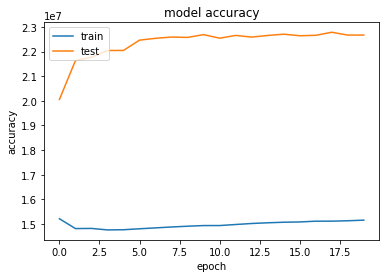

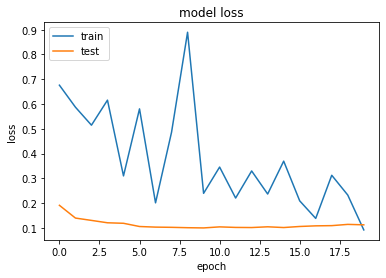

In [16]:
train(model, epoch=20)
# val(model)


In [ ]:
torch.save()

In [17]:
# test code for Mean iou
# a = torch.randn(1, 7, 3, 3)
# # print(a)
# print(a)
# a = torch.torch.nn.functional.log_softmax(a, dim=1)
# print(a.shape)
# print(a)
# a = a.numpy()
# print(a.shape)
outs = np.empty((0,512,512))
b = torch.randn(7,512,512).numpy()
b= np.concatenate((outs,b))
b.shape
# b = torch.argmax(b,dim = 0)
# b = b.numpy()
# mean_iou_evaluate.mean_iou_score(a,b)


(7, 512, 512)

https://zhuanlan.zhihu.com/p/32506912

In [18]:
outs = np.empty((0,512,512))
outs.shape
print(outs)

[]


https://medium.com/ching-i/fully-convolutional-networks-%E8%AB%96%E6%96%87%E9%96%B1%E8%AE%80-246aa68ce4ad

https://github.com/JustinHeaton/fully-convolutional-networks/blob/master/FCN32.ipynb

https://www.malaoshi.top/show_1EF53OZZLiWQ.html

In [19]:
import torch
a = torch.randn(30,7, 512, 512)
# c = a.max(1, keepdim=True)[1]
# c = a.max(1)[1].numpy()
b = torch.argmax(a, dim=1).numpy()
# print(c)
# print(c.shape)
# print(b.shape)
# mean_iou_evaluate.mean_iou_score(c,c)

print(np.concatenate((b, b), axis=0).shape)



(60, 512, 512)


In [20]:
class FCN8(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        # feats = list(models.vgg16(pretrained=True).features.children())

        # self.feats = nn.Sequential(*feats[0:9])
        # self.feat3 = nn.Sequential(*feats[10:16])
        # self.feat4 = nn.Sequential(*feats[17:23])
        # self.feat5 = nn.Sequential(*feats[24:30])

        # for m in self.modules():
        #     if isinstance(m, nn.Conv2d):
        #         m.requires_grad = False

        self.fconn = nn.Sequential(
            nn.Conv2d(512, 4096, 7),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        self.score_feat3 = nn.Conv2d(256, num_classes, 1)
        self.score_feat4 = nn.Conv2d(512, num_classes, 1)
        self.score_fconn = nn.Conv2d(4096, num_classes, 1)

    def forward(self, x):
        feats = self.feats(x)
        feat3 = self.feat3(feats)
        feat4 = self.feat4(feat3)
        feat5 = self.feat5(feat4)
        fconn = self.fconn(feat5)

        score_feat3 = self.score_feat3(feat3)
        score_feat4 = self.score_feat4(feat4)
        score_fconn = self.score_fconn(fconn)

        score = F.upsample_bilinear(score_fconn, score_feat4.size()[2:])
        score += score_feat4
        score = F.upsample_bilinear(score, score_feat3.size()[2:])
        score += score_feat3

        return F.upsample_bilinear(score, x.size()[2:])
model = FCN8(7).to(device,)

In [21]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        self.vgg_feature = models.vgg16(pretrained=True).features[:24]
        # print(self.vgg_feature)
        self.vgg_u1 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 2, 2),
        )
        # print(self.vgg_u1)
        self.vgg_u2 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256,2,2),
        )
        # print(self.vgg_u2)
        self.vgg_u3 = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128,2,2),
        )
        # print(self.vgg_u3)
        self.vgg_u4 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64,2,2),
        )
        # print(self.vgg_u4)
        self.vgg_u5 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 7, 1),
        )
        # print(self.vgg_u5)

    def forward(self, x):
        
        f1 = self.vgg_feature[:3]
        f2 = self.vgg_feature[4:8]
        f3 = self.vgg_feature[9:15]
        f4 = self.vgg_feature[16:22]
        
        out1 = self.vgg_feature(x)
        out2 = self.vgg_feature(f1)
        out3 = self.vgg_feature(f2)
        out4 = self.vgg_feature(f3)
        x = self.vgg_feature(f4)

        x = self.vgg_u1(x)
        x = torch.cat((out4,x),dim=1)
        x = self.vgg_u2(x)
        x = torch.cat((out3,x),dim=1)
        x = self.vgg_u3(x)
        x = torch.cat((out2,x),dim=1)
        x = self.vgg_u4(x)
        x = torch.cat((out1,x),dim=1)
        x = self.vgg_u5(x)

        return x


model = UNET().to(device) 
    